In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=0106380f8a7a818a62c834b98a96a5868d5441df1dced774ed1960d6f62e730f
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
pip install yfinance

In [3]:
pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.0
    Uninstalling joblib-1.4.0:
      Successfully uninstalled joblib-1.4.0


In [4]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00


In [5]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.6 MB/s eta 0:00:00


In [6]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.8 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import yfinance as yf
import shap
import ta
shap.initjs()
#import  pandas_datareader.data as web

In [8]:
#series de tiempo

###modelos arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller,acf,pacf,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
###modelos basados en datos
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor,RandomForestRegressor
from sklearn.pipeline import make_pipeline
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#metrica
from sklearn.metrics import mean_absolute_error

In [9]:
import warnings

In [10]:
warnings.filterwarnings('ignore')

In [11]:
plt.style.use('ggplot')

In [ ]:
ecopetrol=yf.Ticker('ECOPETROL.CL')
ecopetrol=ecopetrol.history(start='2023-01-01',end='2024-04-10')
close=ecopetrol[['Close']]
close=close.asfreq('1D')
train=close.loc[:'2024-02-01 00:00:00+00:00',:]
test=close.loc['2024-02-01 00:00:00+00:00':,:]

In [ ]:
close.head()

,Close
Date,
2023-01-02 00:00:00-05:00,2337.745361
2023-01-03 00:00:00-05:00,2244.386475
2023-01-04 00:00:00-05:00,2277.392090
2023-01-05 00:00:00-05:00,2366.979004
2023-01-06 00:00:00-05:00,2495.229492


<Axes: xlabel='Date'>

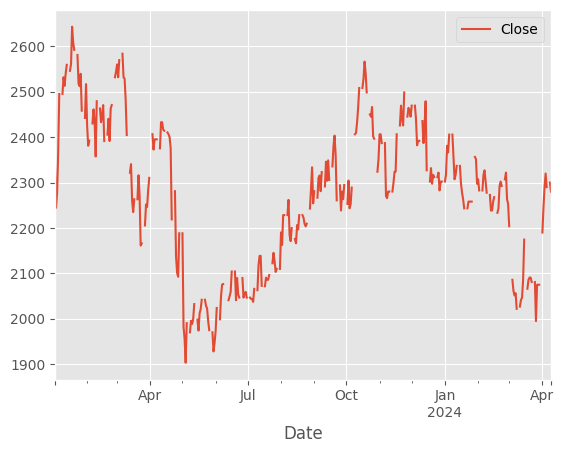

In [ ]:
close.plot()

In [ ]:
close.fillna(method='ffill',inplace=True)

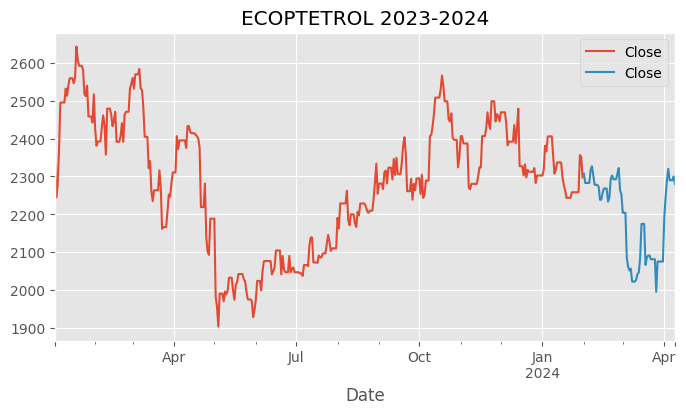

In [ ]:
fig,ax=plt.subplots(figsize=(8,4))
train.plot(ax=ax,label='train')
test.plot(ax=ax,label='test')
ax.set_title('ECOPTETROL 2023-2024')
ax.legend();

###Prueba Dickey Fuller:
* H0: La series tiene una raiz unitaria, no es estacionaria.
* H1: La serie no tiene una raiz unitaria, es estacionaria.

In [ ]:
adfuller(close)[1]

0.11001781292621321


0.11 es mayor que un alfa del 5% por lo cual la serie no es estacioria


### Prueba Kwiatkowski-Phillips-Schmidt-Shin
* H0: La serie es estacionaria.
* H1: La serie no es estacionaria, se requiere diferenciar.

In [ ]:
kpss(close)[1]

0.07508481133252001

El valor es 0.07 por lo que es menor al 5%, por lo que, se rechaza la hipotesis nula es decir, la serie no es estacionaria.

In [ ]:
### serie diferenciada de primer orden
train_diff1=train.diff()

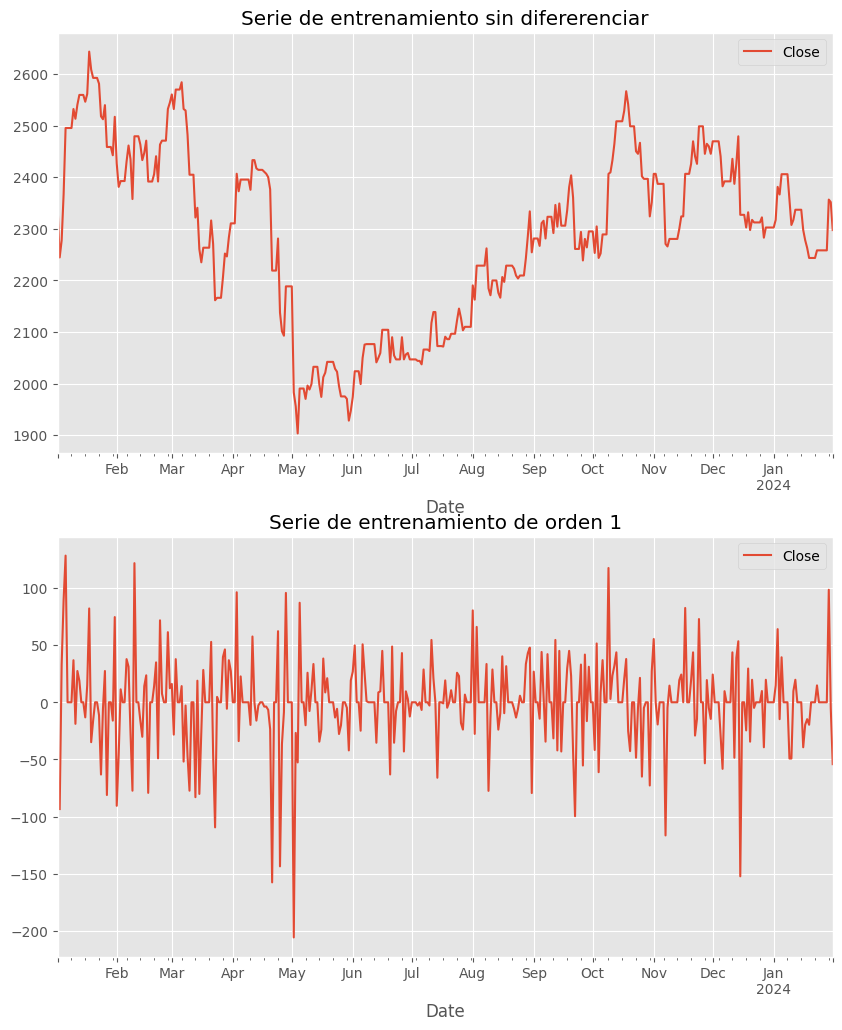

In [ ]:
fig, ax=plt.subplots(2,1,figsize=(10,12))
train.plot(ax=ax[0],title='Serie de entrenamiento sin difererenciar')
train_diff1.plot(ax=ax[1],title='Serie de entrenamiento de orden 1');


In [ ]:
adfuller(train_diff1.dropna())[1]

0.0

Con la diferenciación de orden 1 la serie es ahora estacionaria. Ya que el pvalue 6.72 e-15 es menor a 5% por lo que se rechaza la hipotesis nula.

In [ ]:
kpss(train_diff1.dropna())[1]

0.1

En este caso el p-value es mayor al 5% por lo que no se rechaza la hiótesis nula, es decir, la serie es ahora estacionaria.

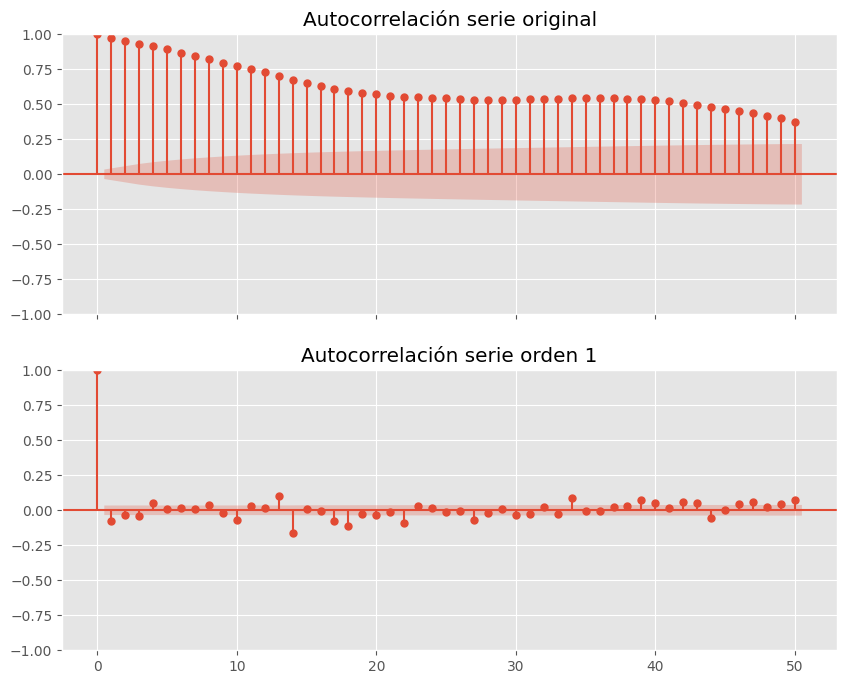

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)
plot_acf(train,ax=ax[0],alpha=0.5,title='Autocorrelación serie original',lags=50)
plot_acf(train_diff1.dropna(),ax=ax[1],alpha=0.5,title='Autocorrelación serie orden 1',lags=50);

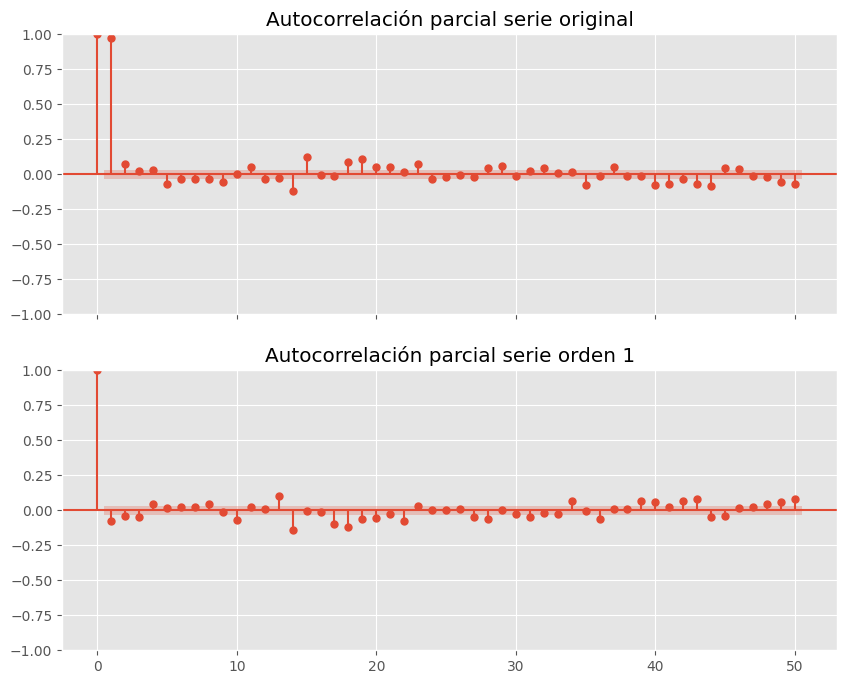

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)
plot_pacf(train,ax=ax[0],alpha=0.5,title='Autocorrelación parcial serie original',lags=50)
plot_pacf(train_diff1.dropna(),ax=ax[1],alpha=0.5,title='Autocorrelación parcial serie orden 1',lags=50);

De acuerdo al gráfico de autocorrelación se puede trabajar para 1 valores de 4, 13 0 14.
A partir del gráfico de autocorrelación parcial se puede usar para p valores de 1,4 o 13.


Text(0.5, 1.0, 'Descomposición de Series')

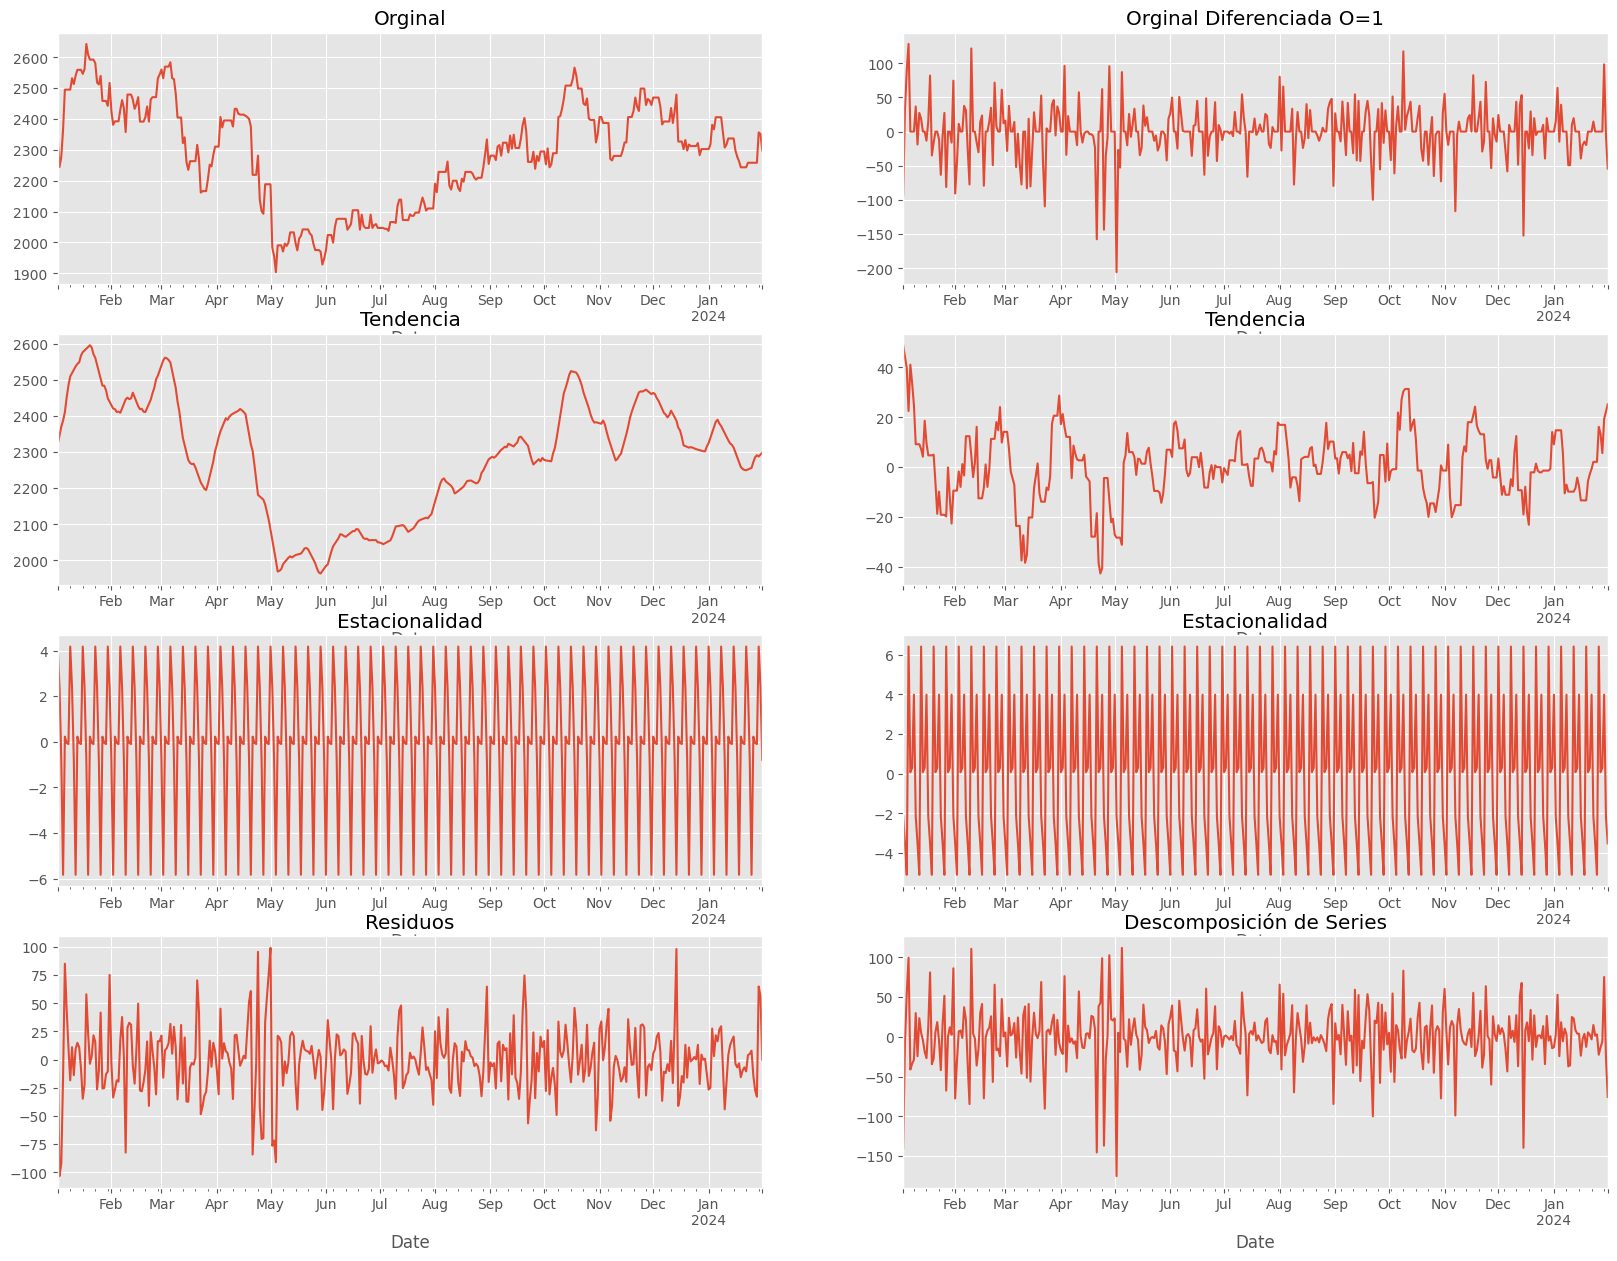

In [ ]:
### descomposición de la serie original y la diferenciada
descompose_1=seasonal_decompose(train,model='additive',extrapolate_trend='freq')
descompose_2=seasonal_decompose(train_diff1.dropna(),model='additive',extrapolate_trend='freq')
fig,ax=plt.subplots(4,2,figsize=(20,15))

descompose_1.observed.plot(ax=ax[0,0],title='Orginal')
descompose_1.trend.plot(ax=ax[1,0],title='Tendencia')
descompose_1.seasonal.plot(ax=ax[2,0],title='Estacionalidad')
descompose_1.resid.plot(ax=ax[3,0],title='Residuos');

descompose_2.observed.plot(ax=ax[0,1],title='Orginal Diferenciada O=1')
descompose_2.trend.plot(ax=ax[1,1],title='Tendencia')
descompose_2.seasonal.plot(ax=ax[2,1],title='Estacionalidad')
descompose_2.resid.plot(ax=ax[3,1],title='Residuos')
plt.title('Descomposición de Series')



En la serie se alcanza a identificar aparantemente un patron de estacionalidad mensual.
De acuerdo a lo anterior una diferenciación estacional con un periodo de una semana, captura los patrones ciclicos de los datos permitiendo alcanzar el procesos estacionario necesario para el modelado ARIMA.

In [ ]:
datos_train_1_7=train.diff().diff(30).dropna()

In [ ]:
print(f'Fuller P-value: {adfuller(datos_train_1_7.dropna())[1]}')

Fuller P-value: 0.0


De acuerdo al p value anterior se rechaza la hipótesis nula es decir, la serie es estacional

#Modelamiento (modelos basados en fórmula)

In [ ]:
### Modelo de statmodels
modelo_sarima=SARIMAX(train,order=(13,1,13),seasonal_oder=(1,1,1,30))## a14 y 14 3988.745
modelo_bitLin=modelo_sarima.fit(disp=0)
modelo_bitLin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  395
Model:             SARIMAX(13, 1, 13)   Log Likelihood               -1970.617
Date:                Tue, 16 Apr 2024   AIC                           3995.233
Time:                        20:19:29   BIC                           4102.595
Sample:                    01-02-2023   HQIC                          4037.775
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5331      0.420     -1.271      0.204      -1.355       0.289
ar.L2         -0.2972      0.216     -1.377      0.169      -0.720       0.126
ar.L3         -0.2444      0.220     -1.110      0.267      -0.676       0.187
ar.L4         -0.0958      0.214     -0.448      0.654      -0.515       0.323
ar.L5         -0.4583      0.197     -2.328      0.020      -0.844      -0.073
ar.L6         -0.7091      0.298     -2.376      0.017      -1.294      -0.124
ar.L7         -0.6382      0.334     -1.909      0.056      -1.293       0.017
ar.L8          0.0542      0.305      0.177      0.859      -0.544       0.653
ar.L9         -0.1547      0.216     -0.717      0.473      -0.577       0.268
ar.L10        -0.2648      0.211     -1.253      0.210      -0.679       0.149
ar.L11        -0.1344      0.201     -0.669      0.504      -0.528       0.260
ar.L12        -0.5053      0.203     -2.489      0.013      -0.903      -0.107
ar.L13        -0.1301      0.331     -0.393      0.695      -0.780       0.519
ma.L1          0.4473      0.412      1.085      0.278      -0.360       1.255
ma.L2          0.2280      0.188      1.213      0.225      -0.140       0.596
ma.L3          0.1610      0.212      0.759      0.448      -0.255       0.577
ma.L4          0.1106      0.185      0.598      0.550      -0.252       0.473
ma.L5          0.4959      0.170      2.916      0.004       0.163       0.829
ma.L6          0.7468      0.299      2.501      0.012       0.162       1.332
ma.L7          0.6852      0.302      2.271      0.023       0.094       1.277
ma.L8         -0.0698      0.284     -0.246      0.806      -0.626       0.486
ma.L9          0.1620      0.198      0.817      0.414      -0.227       0.551
ma.L10         0.2347      0.187      1.257      0.209      -0.131       0.601
ma.L11         0.1890      0.173      1.092      0.275      -0.150       0.528
ma.L12         0.6338      0.190      3.340      0.001       0.262       1.006
ma.L13         0.3129      0.349      0.896      0.370      -0.372       0.997
sigma2      1271.7253     73.413     17.323      0.000    1127.839    1415.611
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               264.70
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predicciones_sarimax_stat=modelo_bitLin.get_forecast(len(test)-1).predicted_mean

In [ ]:
mean_absolute_error(predicciones_sarimax_stat,test.iloc[1:])

120.21768936913698

In [ ]:
### modelo de skforecast
modelo_skforecast=Sarimax(order=(13,1,13),seasonal_order=(1,1,1,30))
modelo_skforecast.fit(train)
modelo_skforecast.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Close   No. Observations:                  395
Model:             SARIMAX(13, 1, 13)x(1, 1, [1], 30)   Log Likelihood               -1871.818
Date:                                Tue, 16 Apr 2024   AIC                           3801.635
Time:                                        20:22:18   BIC                           3914.653
Sample:                                    01-02-2023   HQIC                          3846.555
                                         - 01-31-2024                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4411      0.654     -0.675      0.500      -1.722       0.840
ar.L2         -0.1340      0.694     -0.193      0.847      -1.495       1.227
ar.L3         -0.1003      0.628     -0.160      0.873      -1.331       1.130
ar.L4         -0.0743      0.476     -0.156      0.876      -1.008       0.859
ar.L5         -0.4313      0.419     -1.030      0.303      -1.252       0.390
ar.L6         -0.5431      0.613     -0.886      0.375      -1.744       0.658
ar.L7         -0.4941      0.728     -0.679      0.497      -1.921       0.933
ar.L8          0.1031      0.696      0.148      0.882      -1.262       1.468
ar.L9         -0.3610      0.498     -0.725      0.468      -1.337       0.615
ar.L10        -0.4029      0.493     -0.817      0.414      -1.369       0.563
ar.L11         0.0443      0.558      0.079      0.937      -1.050       1.138
ar.L12        -0.0672      0.564     -0.119      0.905      -1.173       1.039
ar.L13         0.1668      0.500      0.333      0.739      -0.814       1.147
ma.L1          0.3715      0.662      0.561      0.575      -0.926       1.669
ma.L2          0.0815      0.671      0.121      0.903      -1.234       1.397
ma.L3          0.0622      0.601      0.104      0.918      -1.116       1.240
ma.L4          0.1035      0.452      0.229      0.819      -0.781       0.988
ma.L5          0.4872      0.407      1.198      0.231      -0.310       1.284
ma.L6          0.5701      0.642      0.888      0.375      -0.689       1.829
ma.L7          0.5094      0.736      0.692      0.489      -0.933       1.952
ma.L8         -0.1248      0.685     -0.182      0.855      -1.467       1.217
ma.L9          0.3763      0.468      0.803      0.422      -0.542       1.294
ma.L10         0.3919      0.479      0.819      0.413      -0.546       1.330
ma.L11        -0.0195      0.571     -0.034      0.973      -1.139       1.100
ma.L12         0.1182      0.578      0.205      0.838      -1.014       1.250
ma.L13        -0.0127      0.496     -0.026      0.980      -0.984       0.959
ar.S.L30      -0.0120      0.114     -0.106      0.916      -0.235       0.211
ma.S.L30      -0.8028      0.113     -7.104      0.000      -1.024      -0.581
sigma2      1888.5677    195.215      9.674      0.000    1505.953    2271.182
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               104.33
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.55
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer produ

In [ ]:
predicciones_skforecast=modelo_skforecast.predict(steps=(len(test)-1))

In [ ]:
mean_absolute_error(predicciones_skforecast,test.iloc[1:])

113.9644355031636

In [ ]:
predicciones_skforecast.columns=['skforecast']

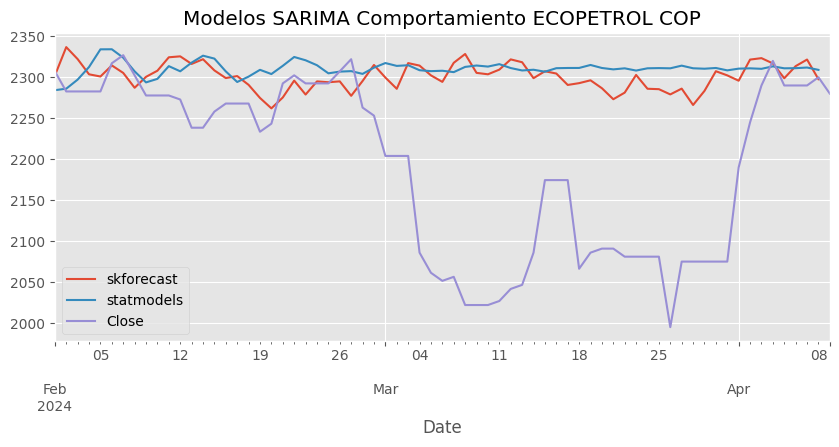

In [ ]:
fig,ax=plt.subplots(figsize=(10,4))
predicciones_skforecast.plot(ax=ax,label='skforecast')
predicciones_sarimax_stat.plot(ax=ax,label='statmodels')
test.plot(ax=ax);
ax.legend()
ax.set_title('Modelos SARIMA Comportamiento ECOPETROL COP');


In [ ]:
### backtesting

forecaster=ForecasterSarimax(
    regressor=Sarimax(order=(1,1,1),seasonal_order=(1,1,1,30),maxiter=200)
)

In [ ]:
metric,predictions=backtesting_sarimax(
    forecaster=forecaster,
    y=close['Close'],
    initial_train_size=len(train),
    fixed_train_size=False,
    steps=len(test),
    metric='mean_absolute_error',
    refit=True,
    n_jobs='auto',
    suppress_warnings_fit=True,
    verbose=False,
    show_progress=True

)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(f'mean abosulte error: {metric}')

mean abosulte error: 107.82167582600023


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
predictions

,pred
2024-02-01 00:00:00-05:00,2302.703110
2024-02-02 00:00:00-05:00,2313.544700
2024-02-03 00:00:00-05:00,2307.935670
2024-02-04 00:00:00-05:00,2300.394723
2024-02-05 00:00:00-05:00,2302.378639
...,...
2024-04-05 00:00:00-04:00,2296.748615
2024-04-06 00:00:00-04:00,2306.883383
2024-04-07 00:00:00-04:00,2313.709630
2024-04-08 00:00:00-04:00,2298.984963


In [ ]:
param_grid={
    'order':[(0,1,0),(1,1,1),(13,1,13),(14,1,14)],
    'seasonal_order':[(1,1,1,30)]

}

In [ ]:
resutl_grid=grid_search_sarimax(
    forecaster=forecaster,
    y=close['Close'],
    param_grid=param_grid,
    steps=len(test),
    refit=True,
    metric='mean_absolute_error',
    initial_train_size=len(train),
    fixed_train_size=False,
    return_best=False,
    n_jobs=1,
    suppress_warnings_fit=False,
    verbose=False,
    show_progress=True)

Number of models compared: 4.


params grid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

In [ ]:
resutl_grid.head()

,params,mean_absolute_error,order,seasonal_order
2,"{'order': (13, 1, 13), 'seasonal_order': (1, 1...",102.586734,"(13, 1, 13)","(1, 1, 1, 30)"
0,"{'order': (0, 1, 0), 'seasonal_order': (1, 1, ...",103.443216,"(0, 1, 0)","(1, 1, 1, 30)"
1,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",107.821676,"(1, 1, 1)","(1, 1, 1, 30)"
3,"{'order': (14, 1, 14), 'seasonal_order': (1, 1...",170.101389,"(14, 1, 14)","(1, 1, 1, 30)"


In [ ]:
forecaster=Sarimax(order=(13,1,13),seasonal_order=(1,1,1,30),maxiter=200)

In [ ]:
forecaster.fit(train)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


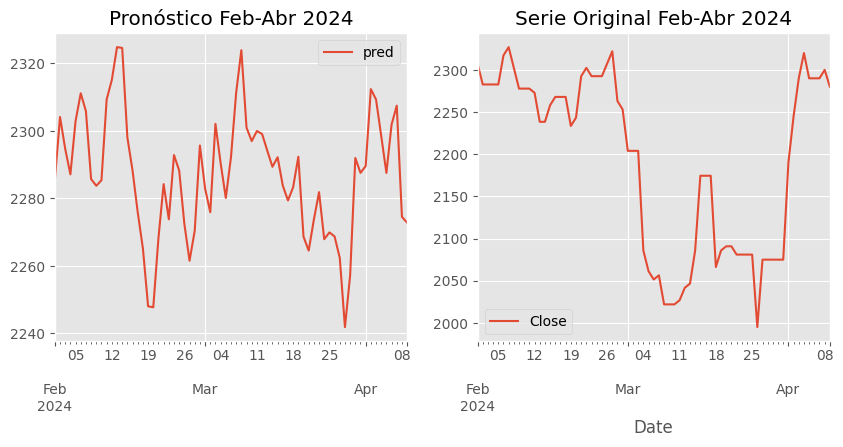

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
forecaster.predict(len(test)).plot(ax=ax[0],title='Pronóstico Feb-Abr 2024')
test.plot(ax=ax[1],title='Serie Original Feb-Abr 2024');

# Modelamiento (modelos basados en datos)

In [12]:
ecopetrol_bg=yf.Ticker('ECOPETROL.CL')#('BTC-USD')
ecopetrol_bg=ecopetrol_bg.history(start='2020-01-01',end='2024-04-10')
close=ecopetrol_bg[['Open','High','Low','Close']]
close=close.asfreq('B')

In [13]:
close.fillna(method='ffill',inplace=True)

In [14]:
#close['RSI']=ta.momentum.rsi(close['Close'].shift(1),fillna=True)

In [15]:
close['RSI']=ta.momentum.rsi(close['Close'].shift(1),fillna=True)

In [16]:
close['WR']=ta.momentum.williams_r(close['High'].shift(1),close['Low'].shift(1),close['Close'].shift(1),fillna=True)

In [17]:
train=close.loc[:'2024-02-01 00:00:00+00:00',:]
test=close.loc['2024-02-01 00:00:00+00:00':,:]
train_data=train.loc[:'2023-08-03 00:00:00+00:00	']
valid_data=train.loc['2023-08-03 00:00:00+00:00':]


In [18]:
close.isna().sum()

Open     0
High     0
Low      0
Close    0
RSI      0
WR       0
dtype: int64

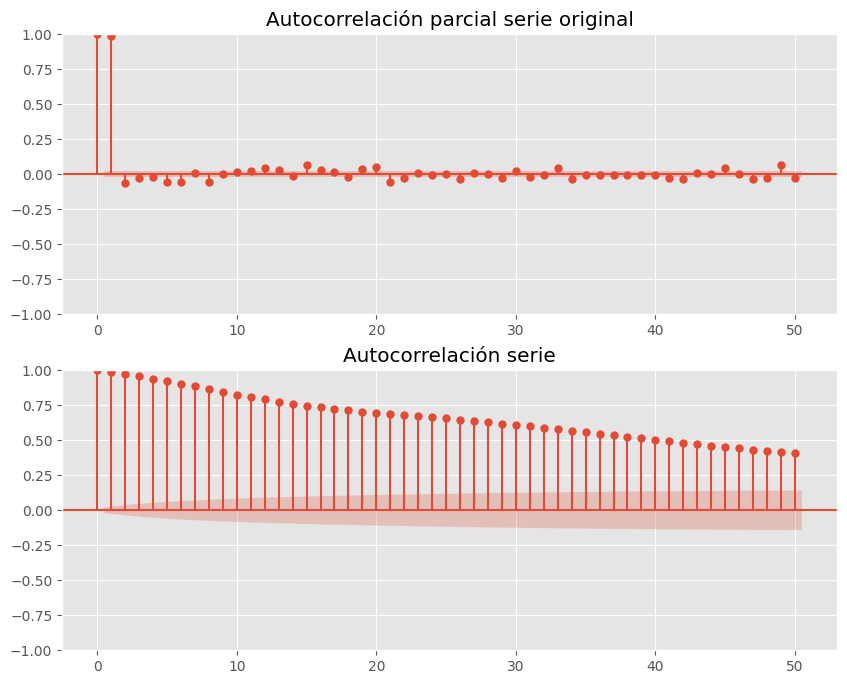

In [19]:
fig,ax=plt.subplots(2,1,figsize=(10,8))#,sharex=True)
plot_pacf(train['Close'],ax=ax[0],alpha=0.5,title='Autocorrelación parcial serie original',lags=50)
plot_acf(train['Close'],ax=ax[1],alpha=0.5,title='Autocorrelación serie',lags=50);#1,15,20,33,49

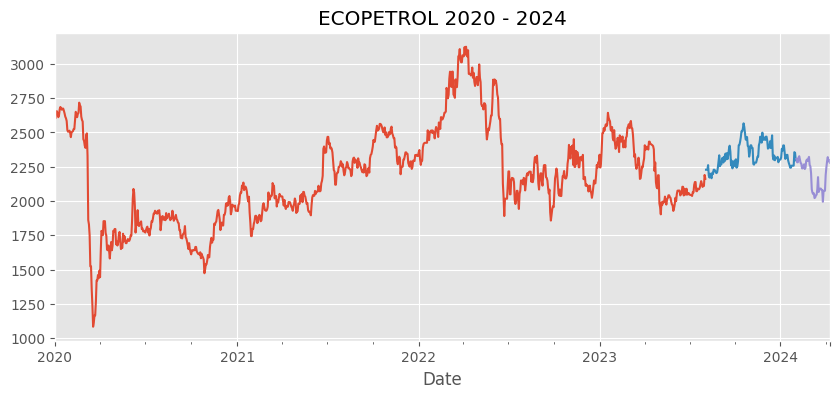

In [20]:
fig,ax=plt.subplots(figsize=(10,4))
train_data['Close'].plot(ax=ax)
valid_data['Close'].plot(ax=ax)
test['Close'].plot(ax=ax)
ax.set_title('ECOPETROL 2020 - 2024');

##Modelo LGBM (variables exogenas)

In [21]:
forecaster=ForecasterAutoreg(
    regressor=LGBMRegressor(random_state=123,verbose=-1),
    lags=15
)

In [22]:
forecaster.fit(train['Close'],exog=train[['RSI','WR']])

In [23]:
metric,predic_baseline=backtesting_forecaster(
    forecaster=forecaster,
    y=close['Close'],
    exog=close[['RSI','WR']],
    steps=len(test),
    metric='mean_absolute_error',
    initial_train_size=len(close.loc[:'2024-02-01 00:00:00+00:00	']),
    refit=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
metric

112.44367061839458

In [25]:
forecaster.get_feature_importances().sort_values(by='importance',ascending=False)

,feature,importance
0,lag_1,382
15,RSI,266
7,lag_8,214
16,WR,211
14,lag_15,192
2,lag_3,182
12,lag_13,169
3,lag_4,159
11,lag_12,151
1,lag_2,150


In [26]:
diccionario={'LGBM':[metric]}

In [27]:
diccionario

{'LGBM': [112.44367061839458]}

In [28]:
### búsqueda de hiperparámetros
lags_grid=[1,15,20,33,49,[1,15,20,33,49]]#19,25,47
def search_space(trial):
 search_space={'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 80, 90, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),}
 return search_space
result_search,frozen_trial=bayesian_search_forecaster(
    forecaster=forecaster,
    y=train['Close'],
    exog=train[['RSI','WR']],
    search_space=search_space,
    lags_grid=lags_grid,
    steps=len(test),
    refit=False,
    metric='mean_absolute_error',
    initial_train_size=len(train_data),
    fixed_train_size=False,
    n_trials=100,
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True

)

Number of models compared: 600,
         100 bayesian search in each lag configuration.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'n_estimators': 400, 'max_depth': 86, 'learning_rate': 0.04749160957089931, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 1.0}
  Backtesting metric: 63.58436710731862



In [29]:
result_search.head()

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
63,[1],"{'n_estimators': 400, 'max_depth': 86, 'learni...",63.584367,400.0,86.0,0.047492,0.7,1.0
253,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 600, 'max_depth': 87, 'learni...",66.665962,600.0,87.0,0.010449,0.5,0.6
360,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 800, 'max_depth': 85, 'learni...",67.041789,800.0,85.0,0.083088,1.0,0.3
397,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1200, 'max_depth': 89, 'learn...",67.173868,1200.0,89.0,0.010077,0.8,0.9
293,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 600, 'max_depth': 88, 'learni...",67.407771,600.0,88.0,0.010074,1.0,0.6


In [30]:
## backtesting LGBMRegressor
metric,predict=backtesting_forecaster(
    forecaster,
    y=close['Close'],
    exog=close[['RSI','WR']],
    steps=len(test),
    metric='mean_absolute_error',
    initial_train_size=len(train),
    refit=False,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
print(f"MAE: {metric}")

MAE: 107.70263457543024


In [32]:
diccionario['LGBM search']=metric

In [33]:
predict_LGBM_S=forecaster.predict(len(test),exog=test.iloc[:,[-2,-1]])

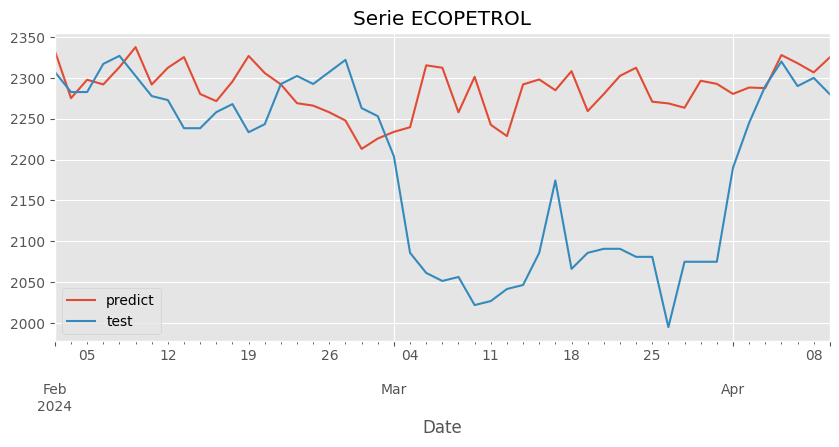

In [34]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
predict_LGBM_S.plot(ax=ax,label='predict',title='Serie pronóstico ECOPETROL Modelo LGBM')
test['Close'].plot(ax=ax,label='test',title='Serie ECOPETROL')
ax.legend();

###Modelo LGBM con variable exógena adicional

In [35]:
def Feature_Var_While(x):
  return pd.Series({'Seno_mes':np.sin(2*np.pi*x['month']/12),'Coseno_mes':np.cos(2*np.pi*x['month']/12)})


In [36]:
close['month']=close.index.month.astype('float64')

In [37]:
close.dtypes

Open     float64
High     float64
Low      float64
Close    float64
RSI      float64
WR       float64
month    float64
dtype: object

In [38]:
close[['Seno','Coseno']]=close.apply(Feature_Var_While,axis=1)

In [39]:
del close['month']

In [40]:
train=close.loc[:'2024-02-01 00:00:00+00:00',:]
test=close.loc['2024-02-01 00:00:00+00:00':,:]
train_data=train.loc[:'2023-08-03 00:00:00+00:00	']
valid_data=train.loc['2023-08-03 00:00:00+00:00':]

In [41]:
forecaster=ForecasterAutoreg(
    regressor=LGBMRegressor(random_state=123,verbose=-1),
    lags=19
)

In [42]:
### búsqueda de hiperparámetros
lags_grid=[1,15,20,33,49,[1,15,20,33,49]]#19,25,47
def search_space(trial):
 search_space={'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),}
 return search_space

In [43]:
result_search,frozen_trial=bayesian_search_forecaster(
    forecaster=forecaster,
    y=train['Close'],
    exog=train.loc[:,['RSI','WR','Seno','Coseno']],

    search_space=search_space,
    lags_grid=lags_grid,
    steps=len(test),
    refit=False,
    metric='mean_absolute_error',
    initial_train_size=len(train_data),##aca toma los inciales de entrenamiento para que sobre validacion
    fixed_train_size=False,
    n_trials=100,
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True

)

Number of models compared: 600,
         100 bayesian search in each lag configuration.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1 15 20 33 49] 
  Parameters: {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.02750908208497425, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}
  Backtesting metric: 51.6116575346887



In [44]:
#prueba con los datos de test
metric,predic=backtesting_forecaster(
    forecaster=forecaster,
    y=close['Close'],
    exog=close.loc[:,['RSI','WR','Seno','Coseno']],
    steps=len(test),
    metric='mean_absolute_error',
    initial_train_size=len(train),#no se usa train data porque aca no se necesitan los de validacion
    refit=False,
    n_jobs='auto',
    verbose=False,
    show_progress=True

)

  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
print(f'MAE: {metric} ')

MAE: 123.49905785572568 


In [46]:
diccionario['LGBM search + month']=metric

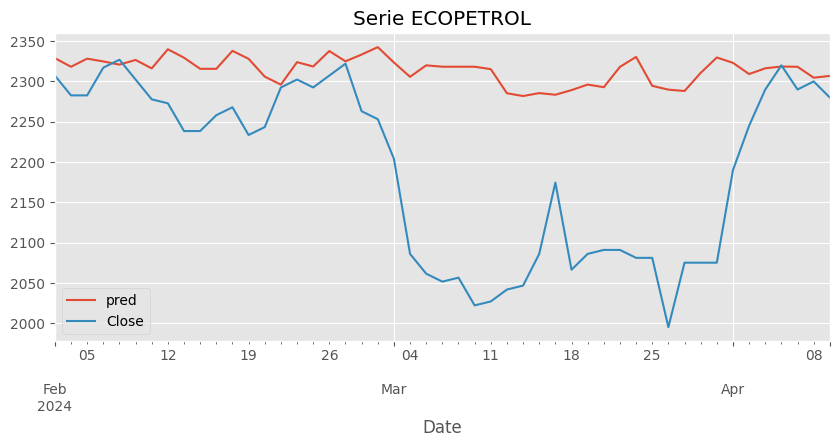

In [47]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
predic.plot(ax=ax,label='predict',title='Serie pronóstico ECOPETROL Modelo LGBM')
test[['Close']].plot(ax=ax,label='test',title='Serie ECOPETROL');

In [48]:
forecaster.get_feature_importances().sort_values(by='importance',ascending=False)

,feature,importance
0,lag_1,929
3,lag_33,581
2,lag_20,578
5,RSI,536
4,lag_49,520
1,lag_15,415
6,WR,296
8,Coseno,152
7,Seno,64


##Generar explicabilidad

In [49]:
#matrices para entrenar un regresor y generar explicabilidad
x_train,y_train=forecaster.create_train_X_y(y=train['Close'],
                                            exog=train[['RSI','WR','Seno','Coseno']])

In [50]:
#como influyen las variables en las predicciones
exp=shap.TreeExplainer(forecaster.regressor)

In [51]:
#seleccionar muestra de 50% de los datos
rg=np.random.default_rng(seed=123)
sample=rg.choice(x_train.index,size=int(len(x_train)*0.5),replace=False)

In [52]:
x_train_sample=x_train.loc[sample]

In [53]:
shap_val=exp.shap_values(x_train_sample)

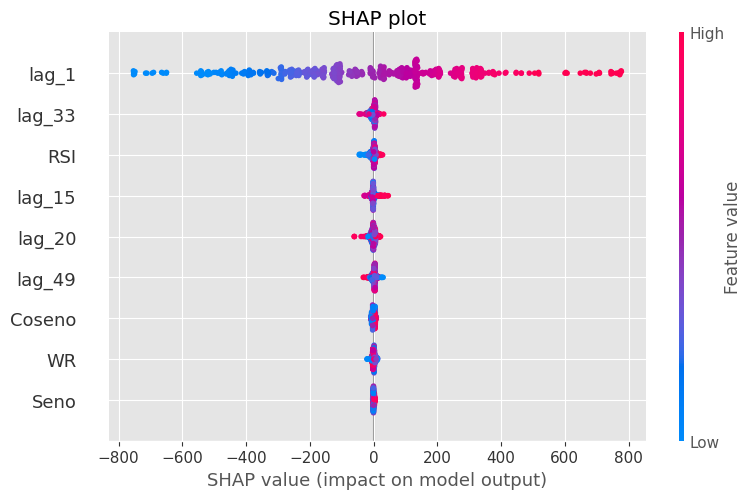

In [54]:
fig,ax=plt.gcf(),plt.gca()
ax.set_title('SHAP plot')
shap.summary_plot(shap_val,x_train_sample,max_display=10)

In [55]:
shap.force_plot(exp.expected_value,shap_val[0,:],x_train_sample.iloc[0,:])

## Modelo XGBoost

In [56]:
# forecaster

forecaster=ForecasterAutoreg(
    regressor=XGBRegressor(tree_method='hist',random_state=123),
    lags=47,
)

In [57]:
lags_grid=[1,15,20,33,49,[1,15,20,33,49]]

In [58]:
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1500, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 10, 20, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
    }
    return search_space

In [59]:
result,frozen_trial=bayesian_search_forecaster(
    forecaster=forecaster,
    y=train['Close'],
    exog=train[['RSI','WR','Seno','Coseno']],
    initial_train_size=len(train_data),
    search_space=search_space,
    lags_grid=lags_grid,
    steps=len(test),
    fixed_train_size=False,
    n_trials=30,
    random_state=123,
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True

)

Number of models compared: 180,
         30 bayesian search in each lag configuration.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] 
  Parameters: {'n_estimators': 600, 'max_depth': 16, 'learning_rate': 0.28617362097868515, 'subsample': 0.8527367648782009, 'colsample_bytree': 0.7156382998513031, 'gamma': 0.7272839045726354, 'reg_alpha': 0.5148814193175779, 'reg_lambda': 0.4091909594806587}
  Backtesting metric: 43.89881310096154



In [61]:
metric_xgb,predic_xgb=backtesting_forecaster(
    forecaster,
    y=close['Close'],
    exog=close[['RSI','WR','Seno','Coseno']],
    initial_train_size=len(train_data),
    fixed_train_size=False,
    steps=len(test),
    refit=False,
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=False,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [62]:
print(f"MAE XGBoost: {metric_xgb}")

MAE XGBoost: 72.75140073978702


In [63]:
diccionario['XGBoost']=metric_xgb

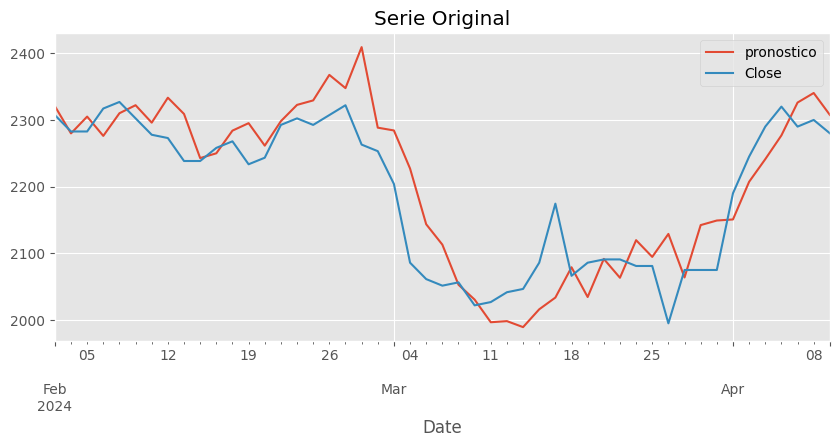

In [86]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
forecaster.predict(steps=len(test.iloc[:,0]),exog=test[['RSI','WR','Seno','Coseno']]).plot(ax=ax,label='pronostico',title='Pronóstico ECOPETROL XGBoost')
test[['Close']].plot(ax=ax,title='Serie Original',label='test')
ax.legend();

##Modelo HistGradientBoost

In [88]:
forecaster=ForecasterAutoreg(
    regressor=HistGradientBoostingRegressor(random_state=123),

    lags=19
)

In [97]:
lags_grid=[[2,3,19,47,60,100,167]]
def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 400, 1200, step=100),
        'max_depth'         : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 1),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20, step=1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1)
    }
    return search_space

In [98]:
result_histgradient,frozen_trial=bayesian_search_forecaster(
    forecaster=forecaster,
    y=train['Close'],
    exog=train[['RSI','WR','Seno','Coseno']],
    search_space=search_space,
    lags_grid=lags_grid,
    steps=len(test),
    refit=False,
    metric='mean_absolute_error',
    initial_train_size=len(train_data),
    fixed_train_size=False,
    n_trials=30,
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

Number of models compared: 30,
         30 bayesian search in each lag configuration.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  2   3  19  47  60 100 167] 
  Parameters: {'max_iter': 1200, 'max_depth': 3, 'learning_rate': 0.06045266837878549, 'min_samples_leaf': 17, 'l2_regularization': 0.16296851966149184}
  Backtesting metric: 57.9614506300311



In [99]:
metric_histgradient,predict_histgradient=backtesting_forecaster(
    forecaster=forecaster,
    y=close['Close'],
    exog=close[['RSI','WR','Seno','Coseno']],
    initial_train_size=len(train),
    steps=len(test),
    fixed_train_size=False,
    refit=False,
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=False
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
print(f"MAE: {metric_histgradient}")

MAE: 43.4181661487889


In [101]:
diccionario['HistGradient']=metric_histgradient

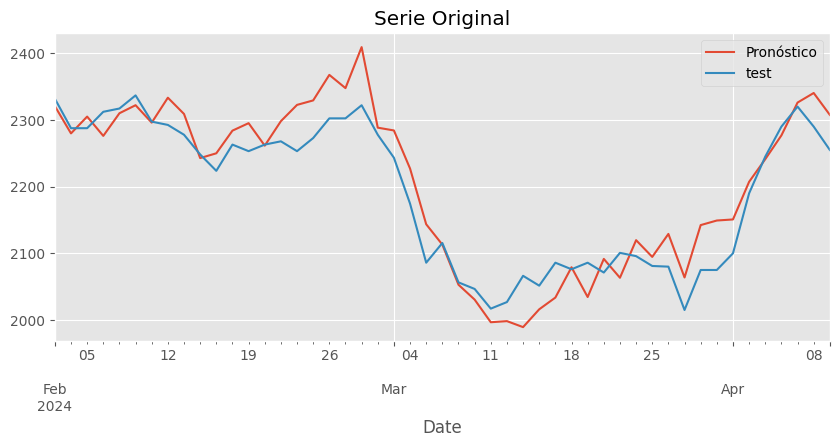

In [102]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
forecaster.predict(steps=len(test[['Close']]),exog=test[['RSI','WR','Seno','Coseno']]).plot(ax=ax,label='Pronóstico')
test.iloc[:,0].plot(ax=ax,label='test',title='Serie Original')
plt.legend();

In [103]:
resultados=pd.DataFrame(diccionario,index=['MAE Backtesting'])

In [104]:
resultados

,LGBM,LGBM search,LGBM search + month,XGBoost,HistGradient
MAE Backtesting,112.443671,107.702635,123.499058,72.751401,43.418166


El modelo con el mejor resultado a 49 es HistGradient